# Distributed Hyperparameter Optimization with Dask and Optuna

Optuna is a very powerful open source framework that helps automate hyperparameter search, and it integrates with Dask allowing you to run optimization trials in parallel on a cluster.

This example walks through a workload which uses Dask and Optuna, to optimize an XGBoost classification model in parallel across a Dask cluster.

You can {download}`download this jupyter notebook <dask-optuna-hpo.ipynb>` and watch the video below to follow along:

<iframe width="560" height="315" src="https://www.youtube.com/embed/_x7oaSEJDjA?start=1305" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


## Before you start

You'll first need install the necessary packages. For the purposes of this example, we'll do this in a new virtual environment, but you could also install them in whatever environment you're already using for your project.

```bash
$ conda create -n dask-optuna-example -c conda-forge python=3.10 optuna dask coiled xgboost sklearn matplotlib
$ conda activate dask-optuna-example
```
  
You also could use `pip`, or any other package manager you prefer; `conda` isn't required.

When you create a cluster, Coiled will automatically replicate your local `dask-optuna-example` environment in your cluster.

## Get a Coiled Cluster

To start we need to spin up a Dask cluster

In [ ]:
import coiled

cluster = coiled.Cluster(
    n_workers=20,
    name="dask-optuna-hpo",
)

and then connect Dask to your remote Coiled cluster.

In [ ]:
from dask.distributed import Client

client = Client(cluster)
client

## Optuna Study

We create a simple in-memory Optuna study and we ship it off to Dask, which will handle the coordination of the results. 

The Dask integration with Optuna leverages Optuna’s existing distributed optimization capabilities to run optimization trials in parallel on a Dask cluster. It does this by providing a Dask-compatible storage `optuna.integration.DaskStorage` that can be used directly by Optuna.

:::{note}
Usually we see people setting up a database at this step to coordinate results. However, in this case there is no need of a database, Dask can happily coordinate this (unless you already have a database handy).
:::


In [ ]:
import optuna

backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage)

study = optuna.create_study(
    direction="maximize",
    storage=dask_storage,  # This makes the study Dask-enabled
    sampler=optuna.samplers.RandomSampler(),
)

## Objective function

In this example we use Optuna to optimize several hyperparameters for an XGBoost classifier trained on the breast cancer dataset.

There is no Dask-specific code here. This is exactly the same code you would write if you were to run Optuna on your local machine.

In [4]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, cross_val_score


def objective(trial):
    X, y = load_breast_cancer(return_X_y=True)

    params = {
        "n_estimators": 10,
        "verbosity": 0,
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-8, 100, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "logloss",
    }

    clf = xgb.XGBClassifier(**params)
    fold = KFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(clf, X, y, cv=fold, scoring="neg_log_loss")

    return score.mean()

## Run optimization trials in parallel

All of the actual coordination happens within Optuna. It's Dask's job just to provide a lot of firepower, which we do by submitting the optimize method many times to the cluster.

In [5]:
%%time

from dask.distributed import wait

futures = [
    client.submit(study.optimize, objective, n_trials=1, pure=False) for _ in range(500)
]

_ = wait(futures)

CPU times: user 1.58 s, sys: 190 ms, total: 1.77 s
Wall time: 13.5 s


## Results

In [6]:
study.best_params

{'lambda': 1.1621290394322247e-05,
 'alpha': 9.83092540863607e-05,
 'colsample_bytree': 0.21935162277801334,
 'max_depth': 6,
 'min_child_weight': 0.8163016764545912,
 'learning_rate': 0.5136962894115045,
 'gamma': 2.7556478610454198e-05}

In [7]:
study.best_value

-0.09708305744830134

/var/folders/1y/ydztfpnd11b6qmvbb8_x56jh0000gn/T/ipykernel_56539/1488679482.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


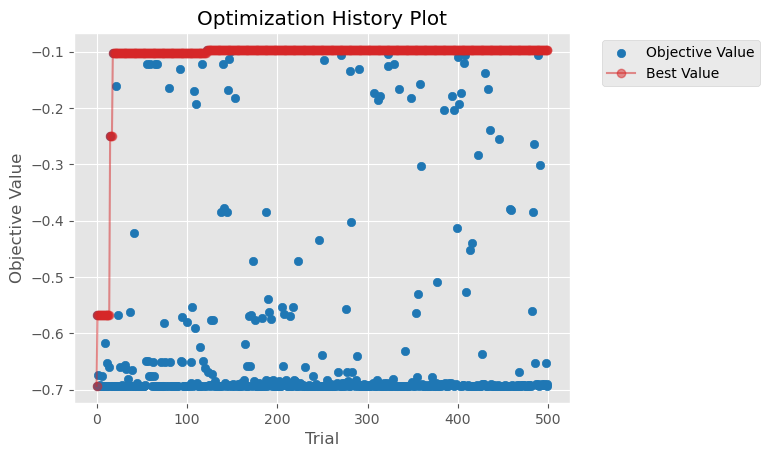

In [8]:
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

plot_optimization_history(study);

## Clean up

In [9]:
cluster.close()